In [4]:
# Install necessary libraries
!pip install pandas numpy scikit-learn nltk matplotlib seaborn keras tensorflow

In [3]:
!pip uninstall keras
!pip install keras

Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-3.4.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? y
  Successfully uninstalled keras-3.4.1
  Using cached keras-3.4.1-py3-none-any.whl.metadata (5.8 kB)
Using cached keras-3.4.1-py3-none-any.whl (1.1 MB)


In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from collections import Counter
import itertools

# For deep learning
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

# For text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Load the dataset

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"subhiksha28","key":"7d8165e0e1d3e41d6ff1eb88b707c82a"}'}

In [8]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 99% 80.0M/80.9M [00:04<00:00, 24.2MB/s]
100% 80.9M/80.9M [00:04<00:00, 17.9MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [10]:
# Load the dataset
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

# Assign column names
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

In [11]:
#Info of the dataset
print('length of data is', len(df))

length of data is 1600000


In [12]:
df.info()

#Check for missing values
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


,0
target,0
id,0
date,0
flag,0
user,0
text,0


sampling the data

In [13]:
# Separate positive and negative samples (assuming 'target' column contains sentiment labels)
positive_samples = df[df['target'] == 4]  # Assuming 4 represents positive sentiment
negative_samples = df[df['target'] == 0]  # Assuming 0 represents negative sentiment

# Sample an equal number of positives and negatives
n_samples = 1000
positive_sampled = positive_samples.sample(n=n_samples, random_state=1)
negative_sampled = negative_samples.sample(n=n_samples, random_state=1)

# Combine and shuffle the samples
senti140_reduced = pd.concat([positive_sampled, negative_sampled]).sample(frac=1, random_state=1).reset_index(drop=True)

print("Balanced dataset created with {} positive and {} negative samples.".format(n_samples, n_samples))

Balanced dataset created with 1000 positive and 1000 negative samples.


In [14]:
# Keep only the 'target' and 'text' columns
senti140_reduced = senti140_reduced[['target', 'text']]
senti140_reduced.head()

,target,text
0,4,ello new follower.
1,0,@nikkibop @troykids i wish i could listen but...
2,0,@MzKikiJ Aww...now i'm sad!!! We didn't go b/c...
3,0,"@jessickak haha k i will when i get home, i le..."
4,0,Sirens are going off


Pre-processing

In [15]:
# Define the text cleaning Regex
TEXT_CLEANING_RE = "@\w+|https?://\S+|[^A-Za-z0-9]+"

# Initialize Lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Pre-process function
def preprocess(text):
    # Remove link, user, and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)

# Apply preprocessing to the text data
senti140_reduced['text'] = senti140_reduced['text'].apply(preprocess)

In [16]:
senti140_reduced.head()

,target,text
0,4,ello new follower
1,0,troykids wish could listen service 6 buck mont...
2,0,aww sad go b c weather channel said gonna rain...
3,0,haha k get home left phone room woops
4,0,siren going


Splitting the data

In [17]:
X = senti140_reduced['text']
y = senti140_reduced['target'].apply(lambda x: 1 if x == 4 else 0)  # Convert sentiment to binary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Tokenizing and padding

In [18]:
# Define maximum number of words and maximum sequence length
max_words = 20000
max_sequence_length = 100

# Tokenize and pad the sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [19]:
max_sequence_length = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

Build and Train the LSTM model

In [20]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128,
                    input_length=max_sequence_length))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
batch_size = 800
epochs = 10
history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.2)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 665ms/step - accuracy: 0.5183 - loss: 0.6927 - val_accuracy: 0.5469 - val_loss: 0.6913
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.5260 - loss: 0.6892 - val_accuracy: 0.5437 - val_loss: 0.6896
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5407 - loss: 0.6857 - val_accuracy: 0.5594 - val_loss: 0.6876
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6168 - loss: 0.6783 - val_accuracy: 0.5781 - val_loss: 0.6843
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6910 - loss: 0.6675 - val_accuracy: 0.6062 - val_loss: 0.6792
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7603 - loss: 0.6518 - val_accuracy: 0.6781 - val_loss: 0.6718
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8096 - loss: 0.6307 - val_accuracy: 0.6500 - val_loss: 0.6641
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7840 - loss: 0.6035 - val_accuracy: 0.5000 - val_loss:

Save the model

In [23]:
model.save('sentiment_lstm_model.h5')
print("Model saved successfully!")

Model saved successfully!


Evaluate the model

In [24]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print('Test Accuracy:', accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5435 - loss: 0.6699
Test Accuracy: 0.5625


In [25]:
#classification report
y_pred = model.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
              precision    recall  f1-score   support

           0       0.50      0.87      0.63       175
           1       0.76      0.32      0.45       225

    accuracy                           0.56       400
   macro avg       0.63      0.60      0.54       400
weighted avg       0.65      0.56      0.53       400



Visualizations

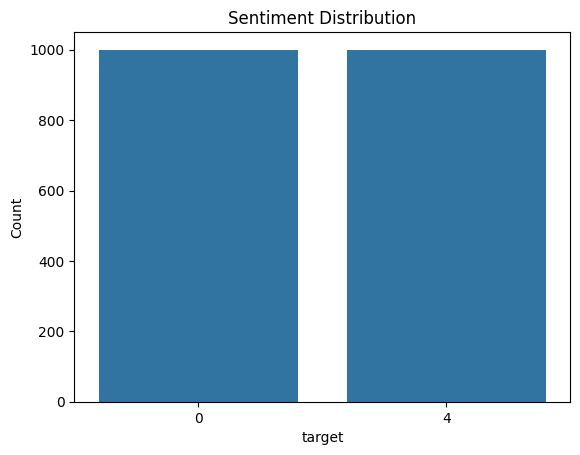

In [26]:
#Distribution of data
sns.countplot(x='target', data=senti140_reduced)
plt.title('Sentiment Distribution')
plt.xlabel('target')
plt.ylabel('Count')
plt.show()

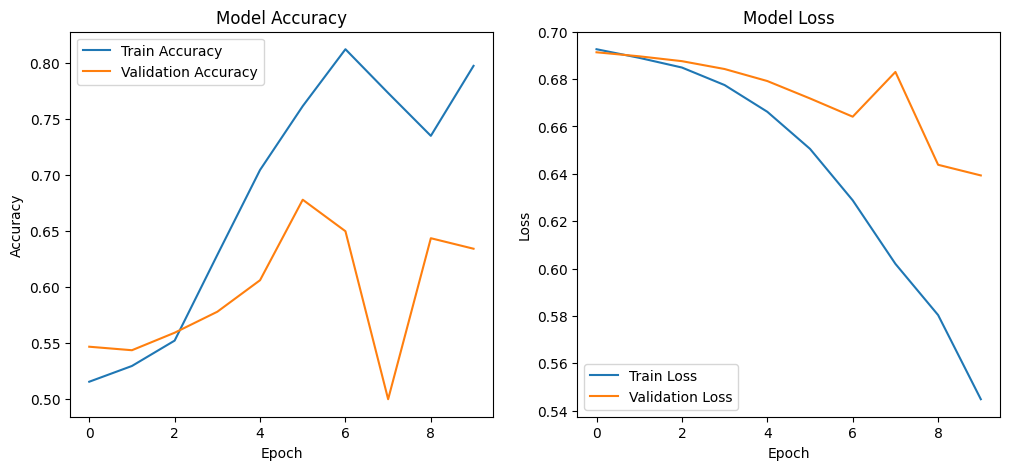

In [27]:
#Accuracy and Loss Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

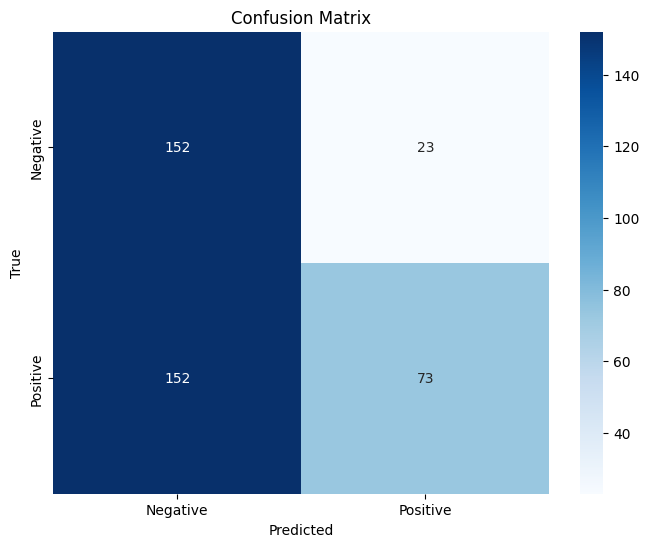

In [28]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

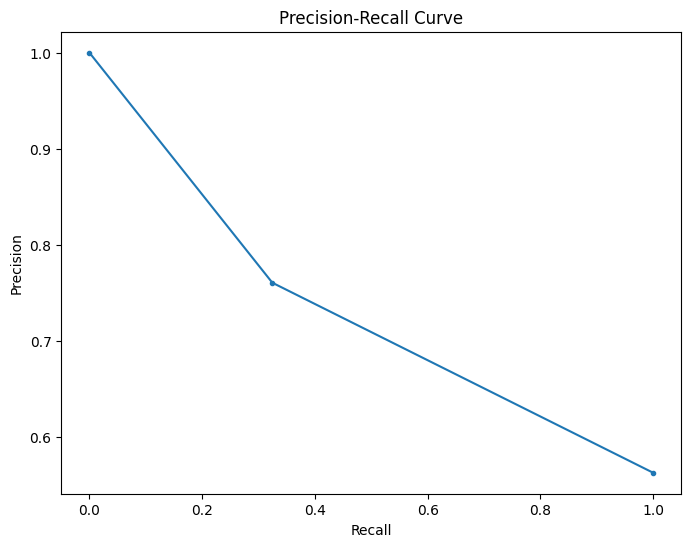

In [29]:
#Per class precision and recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

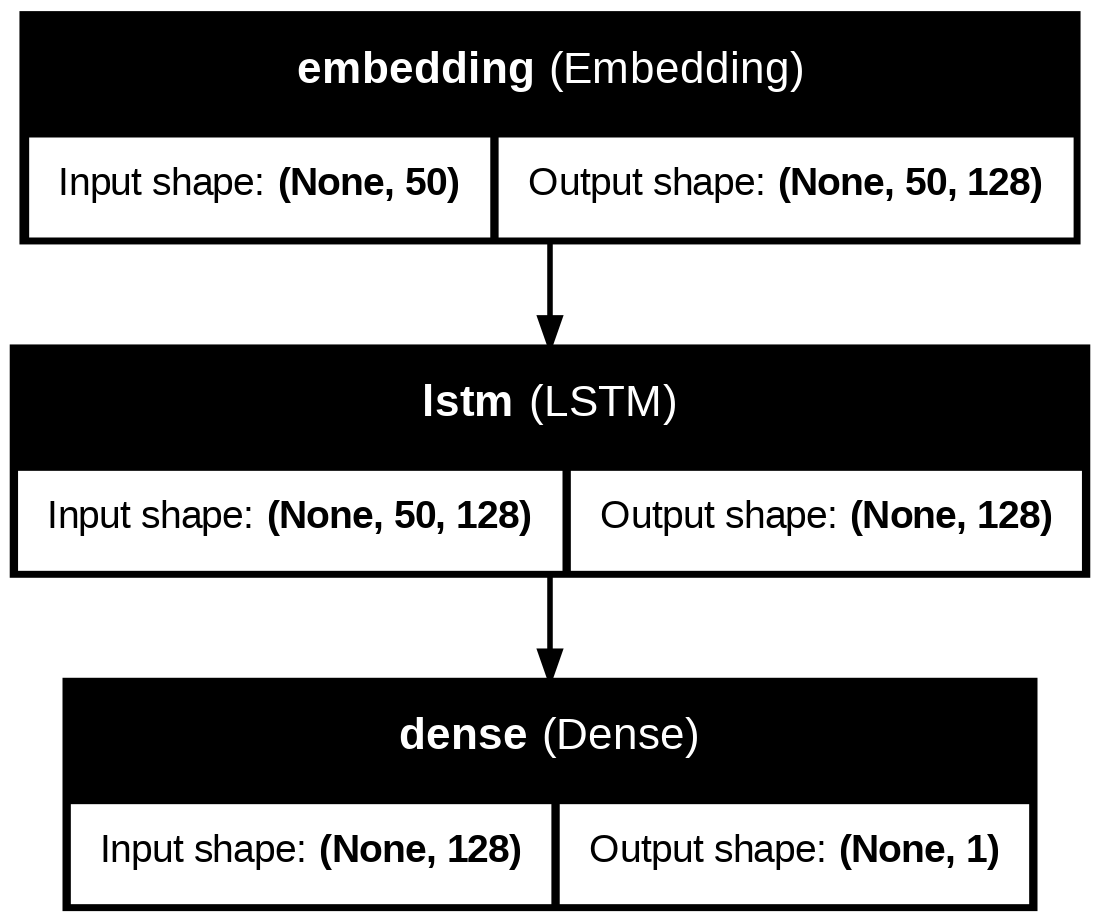

In [30]:
from keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the image
from IPython.display import Image
Image('model_architecture.png')